In [1]:
from os import getenv
import numpy as np
import matplotlib.pyplot as plt
import openvds

from vds_utils import (
    get_minicube,
    get_slice,
    print_channel_info,
    print_crs_metadata,
)


In [2]:
region = 'us-east-1'
# you can code your credentials here, not best practice though.
aws_key = getenv('AWS_ACCESS_KEY_ID')
aws_secret = getenv('AWS_SECRET_ACCESS_KEY')

In [3]:
vds_url = r's3://geophysics-on-cloud/poseidon/seismic/vds/psdn11_TbsdmF_Near_Nov_11_32bit/'
vds_url = r's3://geophysics-on-cloud/poseidon/seismic/vds/psdn11_TbsdmF_Mid_Nov_11_32bit/'
vds_url = r's3://geophysics-on-cloud/poseidon/seismic/vds/psdn11_TbsdmF_Far_Nov_11_32bit/'
vds_url = r's3://geophysics-on-cloud/poseidon/seismic/vds/psdn11_TbsdmF_full_w_AGC_Nov11/'

region_config = f"Region={region}"
key_config = f"AccessKeyId={aws_key}"
secret_config = f"SecretKey={aws_secret}"

aws_config = ';'.join([
    region_config,
    key_config,
    secret_config,
])

In [4]:
vds_handle = openvds.open(
    url=vds_url,
    connectionString=aws_config,
)

layout = openvds.getLayout(vds_handle)

In [5]:
print_channel_info(layout)
print_crs_metadata(layout)

ChannelCount: 3
  Channel Name: Amplitude
    Value range: -15334.1142578125 - 15334.1142578125
  Channel Name: Trace
    Value range: 0.0 - 256.0
  Channel Name: SEGYTraceHeader
    Value range: 0.0 - 256.0
Dimensionality: 3
  Dimension name: Sample
    Number of samples: 1501
    Coordinate min max 0.0 - 6000.0
  Dimension name: Crossline
    Number of samples: 5053
    Coordinate min max 504.0 - 5556.0
  Dimension name: Inline
    Number of samples: 3437
    Coordinate min max 983.0 - 4419.0
SurveyCoordinateSystem::Origin: (409110.54968723457, 8429425.04864461)
SurveyCoordinateSystem::InlineSpacing: (12.052651580247169, 14.363472429446059)
SurveyCoordinateSystem::CrosslineSpacing: (-9.57557031868567, 8.035035629453683)


In [6]:
access_manager = openvds.VolumeDataAccessManager(vds_handle)
axis_descriptors = [layout.getAxisDescriptor(dim) for dim in range(layout.getDimensionality())]
names = [print(axis.getName()) for axis in axis_descriptors]

Sample
Crossline
Inline


In [7]:
il_range = (2550, 2650)
xl_range = (2950, 3050)
z_range = (2000, 4000)

mini_cube = get_minicube(
    access_manager=access_manager,
    layout=layout,
    il_range=il_range,
    xl_range=xl_range,
    z_range=z_range,
)

(500, 2446, 1567, 0, 0, 0)
(1001, 2547, 1668, 1, 1, 1)


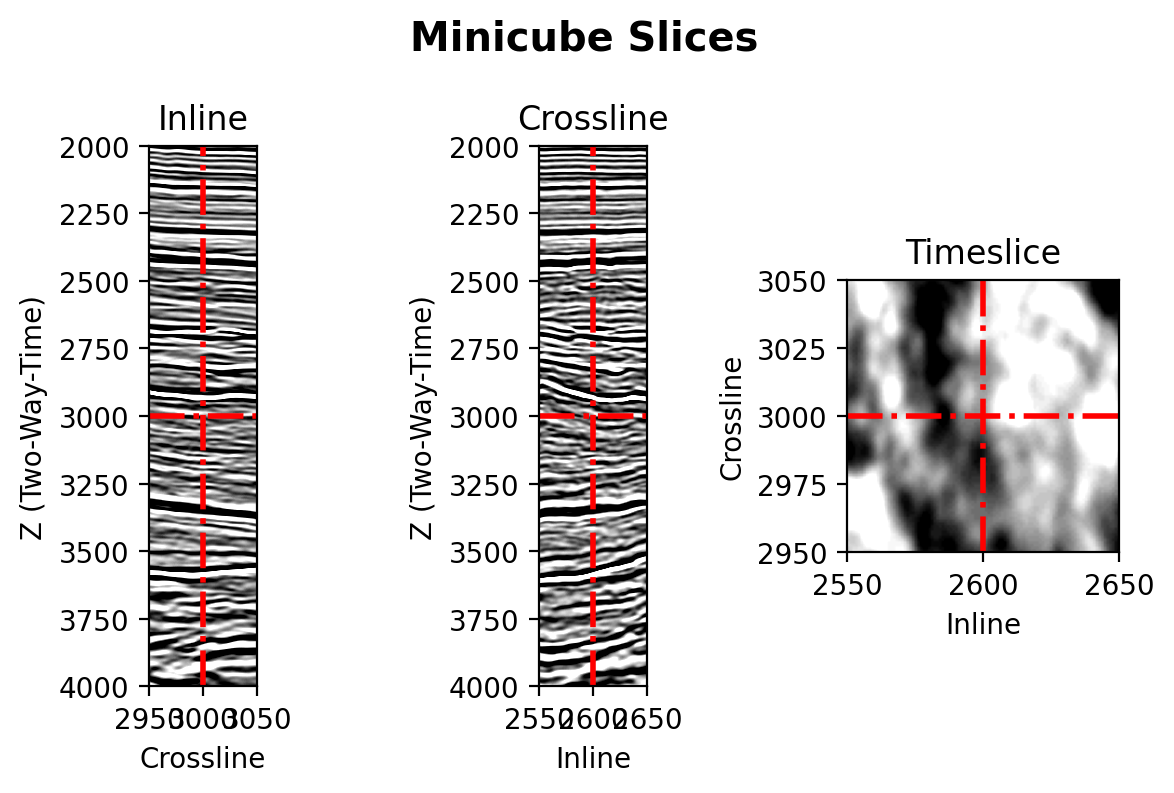

In [8]:
fig, (ax_il, ax_xl, ax_z) = plt.subplots(1, 3, dpi=200)

image_kwargs = {
    'vmin': -5250,
    'vmax': 5250,
    'cmap': 'gray',
}

line_kwargs = {
    'color': 'red',
    'linewidth': 2,
    'linestyle': '-.',
}

n_il, n_xl, n_z = mini_cube.shape
ax_il.imshow(mini_cube[n_il // 2, :, :].T, extent=[*xl_range, *z_range[::-1]], aspect=0.25, **image_kwargs)
ax_il.axvline(np.mean(xl_range), **line_kwargs)
ax_il.axhline(np.mean(z_range), **line_kwargs)
ax_il.set_xlabel('Crossline')
ax_il.set_ylabel('Z (Two-Way-Time)')
ax_il.set_title('Inline')

ax_xl.imshow(mini_cube[:, n_xl // 2, :].T, extent=[*il_range, *z_range[::-1]], aspect=0.25, **image_kwargs)
ax_xl.axvline(np.mean(il_range), **line_kwargs)
ax_xl.axhline(np.mean(z_range), **line_kwargs)
ax_xl.set_xlabel('Inline')
ax_xl.set_ylabel('Z (Two-Way-Time)')
ax_xl.set_title('Crossline')

ax_z.imshow(mini_cube[:, :, n_z // 2].T, extent=[*il_range, *xl_range], aspect=1, origin='lower', **image_kwargs)
ax_z.axhline(np.mean(xl_range), **line_kwargs)
ax_z.axvline(np.mean(il_range), **line_kwargs)
ax_z.set_xlabel('Inline')
ax_z.set_ylabel('Crossline')
ax_z.set_title('Timeslice')

fig.suptitle("Minicube Slices", size='x-large', weight='bold')
fig.tight_layout()

In [9]:
il_slice = get_slice(
    access_manager=access_manager,
    layout=layout,
    slice_type='inline',
    slice_coordinate=2600
)

xl_slice = get_slice(
    access_manager=access_manager,
    layout=layout,
    slice_type='crossline',
    slice_coordinate=3000
)

twt_slice = get_slice(
    access_manager=access_manager,
    layout=layout,
    slice_type='timeslice',
    slice_coordinate=3000
)


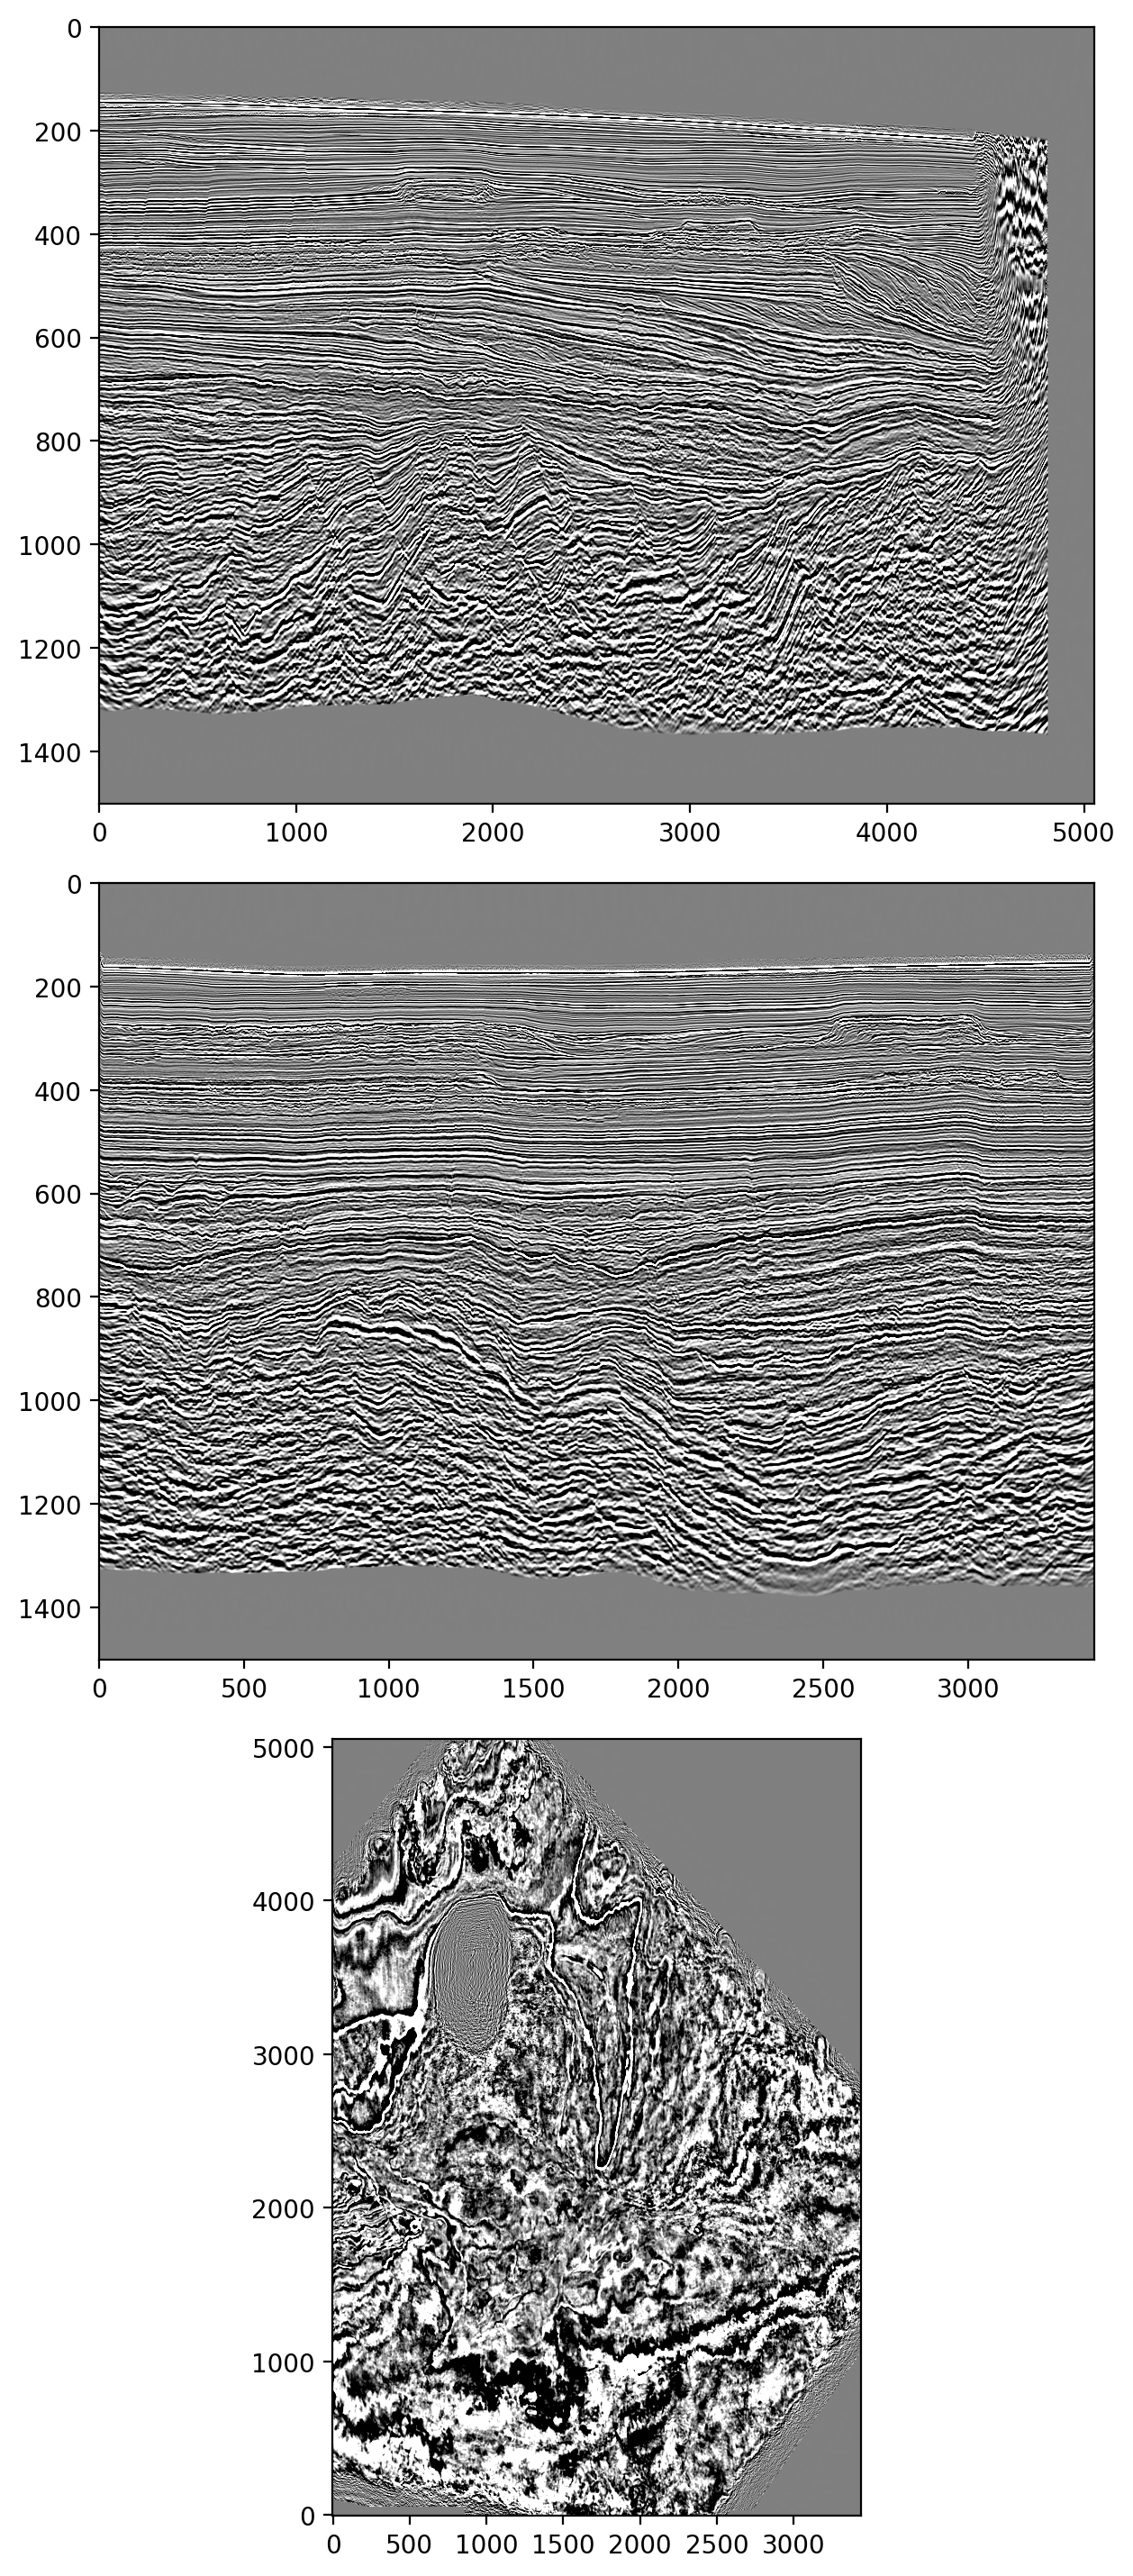

In [10]:
cmap = "gray"
fig, (ax_il, ax_xl, ax_z) = plt.subplots(3, 1, dpi=200, figsize=[6.4, 14.4])
ax_il.imshow(il_slice.T, aspect='auto', **image_kwargs)
ax_xl.imshow(xl_slice.T, aspect='auto', **image_kwargs)
ax_z.imshow(twt_slice.T, aspect=1, origin='lower', **image_kwargs)

fig.tight_layout()

In [11]:
openvds.close(vds_handle)